**Nombre: Arturo Garza Campuzano**

**Matrícula: A00828096**

# Implementación de una técnica de aprendizaje máquina sin el uso de un framework

El dataset utilizado en esta implementación es *Diabetes Dataset* y se puede encontrar en https://www.kaggle.com/datasets/mathchi/diabetes-data-set. En este mismo sitio se puede consultar una breve descripción del mismo.

En este caso se implementó una **regresión logística** sin el uso de framework, cuyo propósito es predecir, en base a medidas diagnósticas, si un paciente tiene diabetes o no. Por lo tanto, este problema puede ser considerado como de clasificación.

## Importar módulos

In [2]:
# Uso general
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Division en subconjuntos de train, test & validation
from sklearn.model_selection import train_test_split
# Analisis de desempeno
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Cargar datos

In [3]:
# Este bloque de codigo no es necesario si el archivo esta guardado localmente
from google.colab import drive
drive.mount('/content/drive')

# Cambiar ruteo con de acuerdo a la ubicacion los archivos en su dispositivo
diabetes_df = pd.read_csv('/content/drive/MyDrive/TC3006C101_A00828096/Aprendizaje_Maquina/diabetes.csv')

#Descripcion de datos
cantidad_registros = len(diabetes_df)
numero_caracteristicas = len(diabetes_df.columns) - 1
valores_salida = diabetes_df["Outcome"].unique()
print("Descripcion de Diabetes Dataset")
print(f"Cantidad de registros: {cantidad_registros}")
print(f"Número de características: {numero_caracteristicas}")
print(f"Valores de salida: {valores_salida}")

Mounted at /content/drive
Descripcion de Diabetes Dataset
Cantidad de registros: 768
Número de características: 8
Valores de salida: [1 0]


## Limpieza del conjunto

El valor cero no es aceptable para algunas variables. Se reemplazan estos valores con la media respectiva a cada variable.

In [4]:
# Se reemplazan los ceros por la media de las variables
zero_not_accepted = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', "Insulin"]

for column in zero_not_accepted:
  diabetes_df[column] = diabetes_df[column].replace(0, np.NaN)
  mean = int(diabetes_df[column].mean(skipna = True))
  diabetes_df[column] = diabetes_df[column].replace(np.NaN, mean)

## Selección de variables de interés

Considerando el propósito del modelo, se sabe que una de las variables de interés es *Outcome*. Sin embargo, tomando en cuenta que el modelo utilizado funciona con dos variables se necesita identificar la **variable de interés** restante. Entre más correlacionadas esten las **variable de interés** más efectivo será el modelo implementado. Siguiendo esta máxima, se elabora un mapa de calor para encontrar la variable de interés que este más correlacionada con *Outcome*.

<ipython-input-5-afa3edeadca8>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.zeros_like(corr, dtype=np.bool),


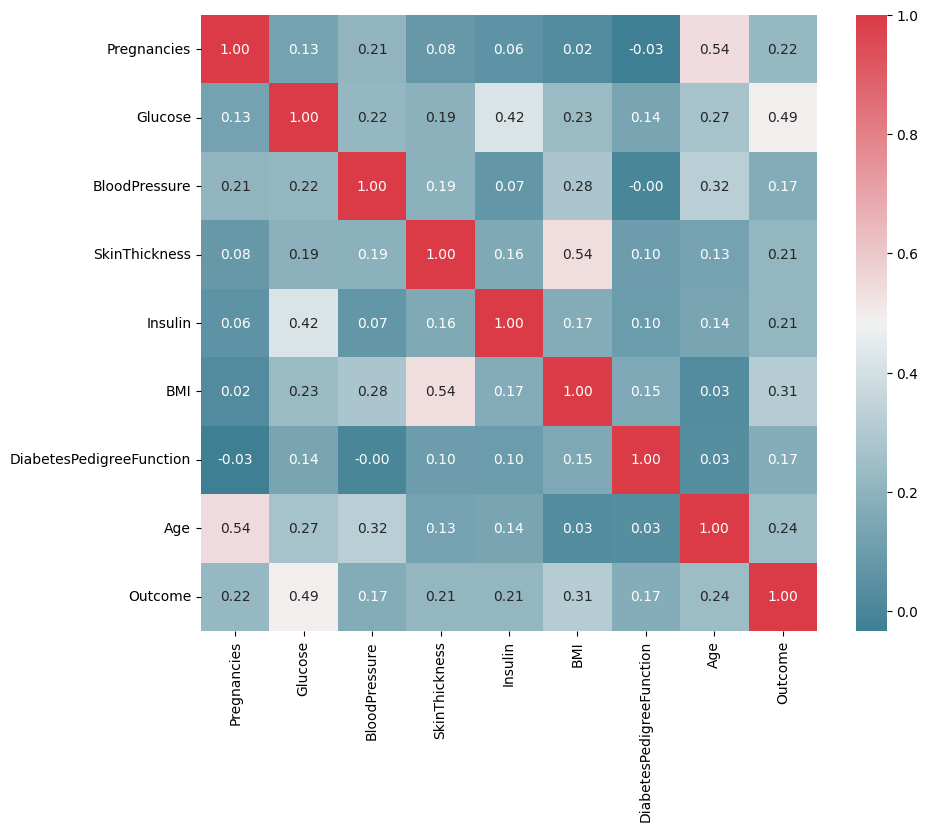

In [5]:
f, ax = plt.subplots(figsize=(10, 8))
corr = diabetes_df.corr()

sns.heatmap(corr,
            annot=True,
            fmt=".2f",
            mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

plt.show()

Observando los resultados del mapa de calor se seleccionan las siguientes **variables de interés**:

- Glucose: variable independeinte.
- Outcome: variable dependiente.

En el siguiente **diagrama de dispersión** se puede visualizar de manera más clara la relación entre las variables de interés. Este diagrama sirve como apoyo para identificar la posición ideal de la función sigmoide.

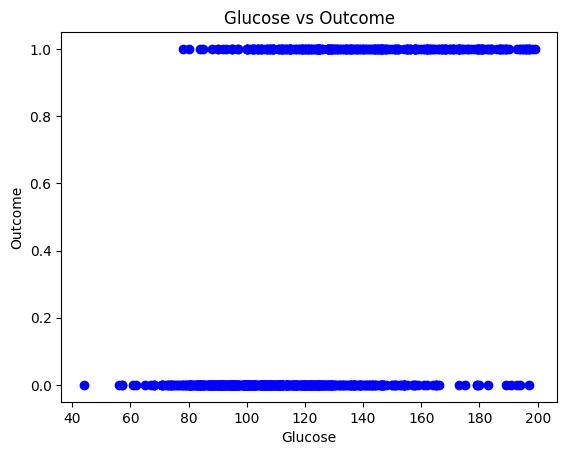

In [6]:
#Vairbales
glucose = diabetes_df['Glucose']
outcome = diabetes_df['Outcome']

# Crea un diagrama de dispersión
plt.scatter(glucose, outcome, label='Data Points', color='blue')

# Add labels and title
plt.xlabel('Glucose')
plt.ylabel('Outcome')
plt.title('Glucose vs Outcome')

# Muestra el diagrama
plt.show()

## Separación del conjunto de datos

In [7]:
# Crear lista con los valores de la variable independiente (maxHR)
X = diabetes_df['Glucose']
# Crear lista con los valores de la variable dependiente (HeartDisease: no = 0, yes = 1)
y = diabetes_df['Outcome']

# Dividir el dataset en conjuntos de entrenamiento (60%) y prueba (40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Entrenamiento del modelo sin framework

Lo primero que se debe hacer es cargar los datos (listas) y los valores iniciales de los hiper-parámetros.

In [8]:
# Crear lista con los hiper-parámetros iniciales (thetas)
theta0 = -8.5
theta1 = 4.5
theta = [theta0, theta1]
# Cargar el valor del learning rate (alpha)
alpha = 0.01

También se necesita una alternativa que permita estimar fácilmente la variable dependiente y el total de muestras. Dado que se implementará la función logística, se ocupa la función exponencial, por lo que se requiere el módulo **math**. También se necesita una variable para el total de iteraciones.

In [9]:
# Crear función lambda para la función de hipótesis
h = lambda x,theta: 1 / (1 + math.exp(-(theta[0] + theta[1] * x)))
# Calcular el total de muestras a partir de los datos (n)
n = len(X_train)
# Definir total de iteraciones a ejecutar
i = 10000

En cada iteración se debe calcular el valor de la derivada de la **función de costo**, que se obtiene a partir de los datos estimados, $h_\theta(x_i)$, y reales, $y_i$ (recuerde que los estimados se obtienen con la función de hipótesis de la regresión logística):

$\frac{∂J_{θ}}{∂θ_0} = \frac{1}{n}\sum_{i=1}^{n}(h_θ(x_i)-y_i)$

$\frac{∂J_{θ}}{∂θ_1} = \frac{1}{n}\sum_{i=1}^{n}(h_θ(x_i)-y_i)x_i$

Además, se deben actualizar los valores de los hiper-parámetros, recordando que $\theta_j=\theta_j-\alpha \frac{∂J_{θ}}{∂θ_j}$:

In [10]:
# Implementar ciclo para iteraciones
for a in range(i):
  # Crear acumuladores
  delta0 = []
  delta1 = []
  # Barrer muestras
  for xi,yi in zip(X_train,y_train):
    pred = h(xi, theta)
    # Calcular delta para theta0 y para cada muestra
    delta0.append(pred-yi)
    # Calcular delta para theta1 y para cada muestra
    delta1.append((pred-yi)*xi)

  # Calcular sumatorias y promedio
  dJt0 = 1/n*sum(delta0)
  dJt1 = 1/n*sum(delta1)

  # Actualizar theta0
  theta0 = theta0 - (alpha*dJt0)
  # Actualizar theta1
  theta1 = theta1 - (alpha*dJt1)

  theta = [theta0, theta1]

Graficamos la **función de hipótesis** resultante, con los valores nuevos de theta.

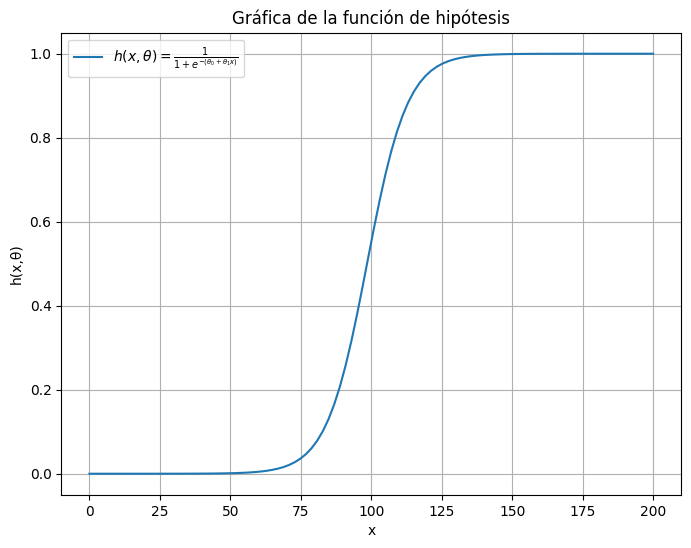

In [11]:
# Genera valores de x
x_values = np.linspace(0, 200, 100)

# Calcular y usar los valores de la funcion lambda
y_values = [h(x, theta) for x in x_values]

# Crear la gráfica
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label=r'$h(x,\theta) = \frac{1}{{1 + e^{-(\theta_0 + \theta_1 x)}}}$')
plt.title('Gráfica de la función de hipótesis')
plt.xlabel('x')
plt.ylabel('h(x,θ)')
plt.grid(True)
plt.legend()
plt.show()

## Evaluación del modelo

### Métricas de desempeño para subconjuntos de entrenamiento y prueba

Se agrupan las **predicciones** de nuestro modelo utilizando la nueva función de hipótesis.

In [12]:
def predicciones(subconjunto):
  # Inicializar acumuladores
  pred = []
  n = len(subconjunto)

  # Barrer la entrada y estimar las salidas:
  for i in range(n):

    # Usar función de hipótesis
    pred_temp = h(subconjunto.iloc[i], theta)

    # Redondear para estimar clase
    pred_temp = round(pred_temp)

    # Acumular
    pred.append(pred_temp)

  return pred

pred_train = predicciones(X_train)
pred_test = predicciones(X_test)

Para estimar qué tan bueno es el clasificador, se genera la **matriz de confusión** y las correspondientes **métricas**:

$accuracy = \frac{VP+VN}{VP+VN+FP+FN}$

$precision = \frac{VP}{VP+FP}$

$recall = \frac{VP}{VP+FN}$

$F1 = \frac{2\cdot precision \cdot recall}{precision+recall}$

In [13]:
def metricas(real, prediccion):

  n = len(real)

  # Inicializar contadores para VP, FP, VN, FN (modelo 1)
  vp = 0
  fp = 0
  vn = 0
  fn = 0

  # Barrer datos reales y predicciones (modelo 1)
  for j in range(n):
    # Analizar opciones para dato real == 1
    if real.iloc[j] == 1:
      # Analizar si predicción == 1 (VP) o == 0 (FN)
      if prediccion[j] == 1:
        vp += 1
      else:
        fn += 1
    # Analizar opciones para dato real == 0
    else:
      # Analizar si predicción == 1 (FP) o == 0 (VN)
      if prediccion[j] == 1:
        fp += 1
      else:
        vn += 1

  # Matriz confusion
  mc = confusion_matrix(real, prediccion)

  # Métricas
  a = (vp + vn)/(vp + vn + fp + fn)
  p = vp / (vp + fp)
  r = vp / (vp + fn)
  f1 = 2*((p*r)/(p+r))

  return mc, a, p, r, f1

mc_train, a_train, p_train, r_train, f1_train = metricas(y_train, pred_train)
mc_test, a_test, p_test, r_test, f1_test = metricas(y_test, pred_test)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [a_train, p_train, r_train, f1_train],
    'Test': [a_test, p_test, r_test, f1_test]
})

# Imprimir resultados
metrics_df

,Metric,Train,Test
0,Accuracy,0.547826,0.529221
1,Precision,0.441667,0.407725
2,Recall,0.957831,0.931373
3,F1 Score,0.604563,0.567164


Como se puede observar en la tabla, las métricas de desempño entre subconjuntos no son tan diferentes, lo cual indica que el modelo ya está bien balanceado. No obstante, la exactitud de los modelos no es tan buena, para mejorarla se necesitarían considerar otras variables.

### Matriz de confusión

Con motivo de comparar entre las predicciones generadas por el modelo y los valores que debieron de obtenerse se grafica la matriz de confusión para los subconjuntos de entrenamiento y prueba.

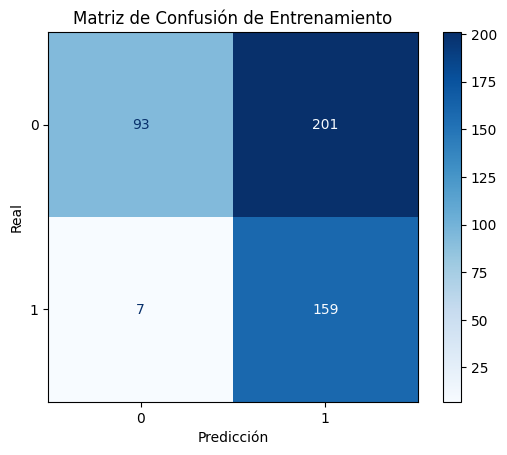

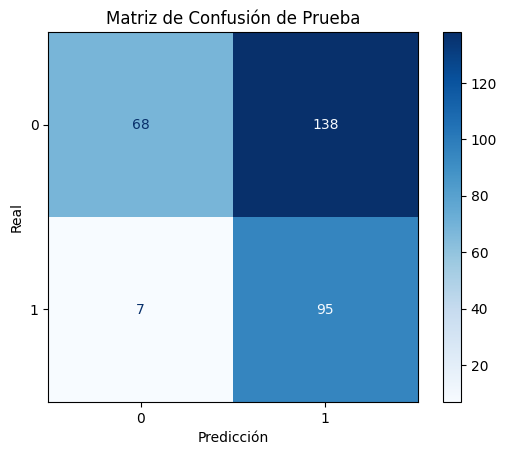

In [14]:
def plot_confusion_matrix(confusion_matrix, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.show()

plot_confusion_matrix(mc_train, "Matriz de Confusión de Entrenamiento")
plot_confusion_matrix(mc_test, "Matriz de Confusión de Prueba")

### Predicciones con modelo entrenado

Después de haber entrenado el modelo se realizan tres predicciones puntuales con datos aleatorios. Estos se comparan con los datos reales extraidos del subconjunto de prueba.

In [16]:
# Obtener la longitud de X_test (y_test tendrá la misma longitud)
n_samples = len(X_test)

# Elegir tres índices aleatorios únicos de X_test
random_indices = random.sample(range(n_samples), min(3, n_samples))

# Obtener las tres muestras de X_test y y_test utilizando los índices seleccionados
three_X_samples = [X_test.iloc[i] for i in random_indices]
three_y_samples = [y_test.iloc[i] for i in random_indices]

data = {'Glucose': three_X_samples}
prueba_df = pd.DataFrame(data)
pred_puntuales = predicciones(prueba_df)

# Crear un diccionario con los datos
data = {
    'Real': three_y_samples,
    'Prediccion': pred_puntuales
}

# Crear el DataFrame
resultado_df = pd.DataFrame(data)

# Imprimir el DataFrame
resultado_df

,Real,Prediccion
0,0,1
1,0,0
2,0,0
